## Appendix A: Impact of increasing Av, with no scatter

In [1]:
import numpy as np
import h5py
from unyt import Msun, Myr, Angstrom, erg, s, Hz
from astropy.cosmology import LambdaCDM

from synthesizer.grid import Grid
from synthesizer.particle import Galaxy
from synthesizer.instruments.filters import FilterCollection

from synthesizer.emission_models import PacmanEmission
from synthesizer.emission_models.attenuation import PowerLaw, Calzetti2000, GrainModels
from synthesizer.emissions.utils import (
    Ha,
    Hb, 
)
from synthesizer.conversions import lnu_to_absolute_mag

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cmasher as cmr

from utilities import calc_line_corr, calc_line_corr_from_Av

cosmo = LambdaCDM(Om0=0.307, Ode0=0.693, H0=67.77, Ob0=0.04825)
plt.style.use('styles/style.mplstyle')

# Set random seed for reproducibility
np.random.seed(680010)

In [2]:
def Ha_to_SFR(Ha):
    """Convert Halpha to SFR using the Kennicut relation.
    
    Args:
        Ha (float): Halpha luminosity in erg/s
        
    Returns:
        float: SFR in Msun/yr
    """
    
    sfr = 10**(-41.36) * Ha
    
    return sfr

def get_data(ii, tag):
    """Retreive FLARES data relevant for this notebook.
    
    Args:
        ii (int): Simulation number (0-39)
        tag (str): Tag for the data to retreive (e.g. 010_z005p000)
    
    Returns:
        tuple: Mstar, MFUVatt, Halpha, Hbeta, Halphaint,
        Hbetaint, MassweightedZ, MFUVint, Av, SFR10
    """

    num = str(ii)

    if len(num) == 1:
        num =  '0'+num

    sim = "./data/flares_shared_data.hdf5"
    num = num+'/'

    with h5py.File(sim, 'r') as hf:
        Mstar   = np.array(hf[num+tag+'/Galaxy/Mstar_aperture'].get('30'), dtype = np.float32)*1e10
        SFR10   = np.array(hf[num+tag+'/Galaxy/SFR_aperture/30'].get('10Myr'), dtype = np.float32)
        
        MassweightedZ = np.array(hf[num+tag+'/Galaxy/Metallicity'].get('CurrentMassWeightedStellarZ'), dtype = np.float32)
        MFUVatt = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('FUV'), dtype = np.float32) * erg / s / Hz
        MFUVint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('FUV'), dtype = np.float32) * erg / s / Hz

        Av = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/DustModelI'].get('V'), dtype = np.float32) / np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Luminosity/Intrinsic'].get('V'), dtype = np.float32)
        Av = -2.5 * np.log10(Av)

        Halpha = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbeta = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/DustModelI/HI4861'].get('Luminosity'), dtype = np.float64)
        Halphaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI6563'].get('Luminosity'), dtype = np.float64)
        Hbetaint = np.array(hf[num+tag+'/Galaxy/BPASS_2.2.1/Chabrier300/Lines/Intrinsic/HI4861'].get('Luminosity'), dtype = np.float64)      


    ok = (Halphaint>0) * (lnu_to_absolute_mag(MFUVatt)<-17)

    return Mstar[ok], MFUVatt[ok], Halpha[ok], Hbeta[ok], Halphaint[ok], Hbetaint[ok], MassweightedZ[ok], MFUVint[ok], Av[ok], SFR10[ok]

In [3]:
# Define the synthesizer grid
grid_name = "bpass-2.2.1-bin_chabrier03-0.1,300.0_cloudy-c23.01-sps"
grid_dir = "./data/" 
grid = Grid(grid_name, grid_dir=grid_dir)

Zsun = 0.014

# Define some of the required lines
req_lines = {'H 1 6562.80A': 'Halpha',
             'H 1 4861.32A': 'Hbeta',
             'O 2 3726.03A,O 2 3728.81A': '[OII]3727,29',
             'O 3 4958.91A': '[OIII]4959',
             'O 3 5006.84A': '[OIII]5007',
             'Ne 3 3868.76A': 'NeIII3869',
             'H 1 1.87510m': 'Paalpha',
             'H 1 1.28181m': 'Pabeta',
             'H 1 1.00494m': 'Pagamma'
             
}

# Define the tophats for required filters
tophats = {
    "UV1500": {"lam_eff": 1500*Angstrom, "lam_fwhm": 300*Angstrom},
    "UV2800": {"lam_eff": 2800*Angstrom, "lam_fwhm": 300*Angstrom},
}

# Define the filter collection for synthesizer
filters = FilterCollection(
    filter_codes=[f'Generic/Johnson.V'],
    tophat_dict=tophats,
    new_lam=grid.lam
)

# Define the lines we want to use
li = [
       Ha,
       Hb, 
   ]

# Wavelengths of the lines we want to use
lam_Ha = 6562.80 * Angstrom
lam_Hb = 4861.32 * Angstrom

### Create toy model galaxies 
(Same across all notebooks)

In [4]:
# An arbitrary redshift to use
redshift = 6.
# Number of star particles
n = 100
ages = 10**np.random.uniform(0, np.log10(50), size=n) * Myr
Z = 10**np.random.uniform(-3.5, -2., size=n)
mass = 1e6*np.random.uniform(2, 5, n) * Msun 

print (r'log$_{10}$(M$_{\star}$/M$_{\odot}$): ', np.log10(np.sum(mass).to('Msun')))

# Dust distributions
# Here we are creating a range of dust distributions with
# different mean optical depths (mu) and some scatter (sigma).
# This case is different from our fiducial case where the we
# were varying the dust distribution but keeping the same mean
# optical depth. Here we are varying the mean optical depth,
# to understand if the variation in proeprties are driven by
# the mean optical depth or the variation in the dust distribution.
max_tau = 7
mu, sigma = 0.3, 0.1
nmu = np.arange(0,max_tau,2)
num_gals = len(nmu)
colors = cmr.take_cmap_colors('cmr.gem_r', num_gals, return_fmt='rgb')

# Property holders
logOH = np.zeros(4)
lum_int = np.zeros(4, dtype=object)
line_int = np.zeros(4, dtype=object)
sed_int = np.zeros(4, dtype=object)

line_emergent = np.zeros((4, num_gals), dtype=object)
sed_emergent = np.zeros((4, num_gals), dtype=object)
lum_att = np.zeros((4, num_gals))
att_curve = np.zeros((4, num_gals, len(grid.lam)))
Av = np.zeros((4, num_gals))

Luv = np.zeros(4)
Halpha_frac_dust = np.zeros((4, num_gals))
Halpha_frac_Avcorr = np.zeros((4, num_gals))
Halpha_frac_balmercorr = np.zeros((4, num_gals))

# Vary everything
gal = Galaxy(redshift=redshift)
gal.load_stars(
    ages=ages,
    metallicities=Z,
    initial_masses=mass 
)
ok = gal.stars.ages<=10*Myr
Zmean = np.sum(gal.stars.initial_masses[ok] * gal.stars.metallicities[ok]) / np.sum(gal.stars.initial_masses[ok])
Agemean = np.sum(gal.stars.initial_masses[ok] * gal.stars.ages[ok]) / np.sum(gal.stars.initial_masses[ok])

# Keep everything fixed
gal_const = Galaxy(redshift=redshift)
gal_const.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary age
gal_vary_age = Galaxy(redshift=redshift)
gal_vary_age.load_stars(
    ages=ages,
    metallicities=np.ones(n) * Zmean,
    initial_masses=mass 
)

# Vary metallicity
gal_vary_Z = Galaxy(redshift=redshift)
gal_vary_Z.load_stars(
    ages=np.ones(n) * Agemean,
    metallicities=Z,
    initial_masses=mass 
)

all_gals = [gal_const, gal_vary_age, gal_vary_Z, gal]

tau_v = np.zeros((num_gals, n))
for ii in range(num_gals):
    tmp  = nmu[ii] * mu + np.random.normal(0, sigma, n)
    tmp[tmp<0] = 0.01
    tau_v[ii] = tmp

for jj, kk in enumerate(all_gals):
    # print ("Galaxy number: ", jj)
    ok = kk.stars.ages<=10*Myr
    Zmean = np.sum(kk.stars.initial_masses[ok] * kk.stars.metallicities[ok]) / np.sum(kk.stars.initial_masses[ok])    
    logOH[jj] = 8.69 + np.log10(Zmean/Zsun)

    for ii in range(num_gals):

        emodel = PacmanEmission(
            grid=grid,
            tau_v=tau_v[ii],
            dust_curve=PowerLaw(),
            per_particle=True
        )   
    
        kk.stars.get_spectra(emission_model=emodel)    
        kk.stars.get_lines(li,
            emodel
        )        
        
        line_emergent[jj][ii] = kk.stars.lines['emergent']
        kk.stars.spectra['emergent'].get_fnu(cosmo=cosmo, z=redshift)   
        tmp = kk.stars.spectra['emergent'].get_photo_lnu(filters, verbose=False)
        lum_att[jj][ii] = tmp['Generic/Johnson.V']
        
        sed_emergent[jj][ii] = kk.stars.spectra['emergent']
        att_curve[jj][ii] = -2.5 * np.log10(kk.stars.spectra['emergent'].luminosity/kk.stars.spectra['intrinsic'].luminosity)

    line_int[jj] = kk.stars.lines['intrinsic']    
    lum_int[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['Generic/Johnson.V']    
    Luv[jj] = kk.stars.spectra['intrinsic'].get_photo_lnu(filters, verbose=False)['UV1500'] 
    sed_int[jj] = kk.stars.spectra['intrinsic']

    Av[jj] = -2.5 * np.log10(lum_att[jj]/lum_int[jj])
    
for jj, kk in enumerate(all_gals):
    for ii in range(num_gals):
        Halpha_frac_dust[jj][ii] = line_emergent[jj][ii]['Ha'].luminosity / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_Avcorr[jj][ii] = calc_line_corr_from_Av(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, Av[jj][ii], slope=0) / line_int[jj]['Ha'].luminosity
        
        Halpha_frac_balmercorr[jj][ii] = calc_line_corr(line_emergent[jj][ii]['Ha'].luminosity, lam_Ha, line_emergent[jj][ii]['Ha'].luminosity/line_emergent[jj][ii]['Hb'].luminosity) / line_int[jj]['Ha'].luminosity

log$_{10}$(M$_{\star}$/M$_{\odot}$):  8.547170992041227


/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/2087732659.py:44: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/2087732659.py:55: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_const.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/2087732659.py:63: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_age.load_stars(
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/2087732659.py:71: RuntimeWarning: 
Current mass of stars not provided, setting stellar_mass_weighted_age to `None`
  gal_vary_Z.load_stars(
/Users/ap629AA/pyvenv/astro_venv/lib/python3.12/site-packages/unyt/array.py:1949: RuntimeWarning: invalid value encountered in divide
  out_arr = func(
/Users/ap629AA/pyvenv/astro_venv/l

#### Spectra and attenuation curve of toy galaxies

Same as Figure 2 in the paper, but now for this special case

<>:23: SyntaxWarning: invalid escape sequence '\d'
<>:23: SyntaxWarning: invalid escape sequence '\d'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/1106101151.py:23: SyntaxWarning: invalid escape sequence '\d'
  axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw, $\delta=-1$', alpha=0.6, ls='dotted', lw=4, color='olive')
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/1106101151.py:20: RuntimeWarning: 
Wavelengths outside the range 102.9 Å - 100000000.0 Å Values are being
extrapolated.
  axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')


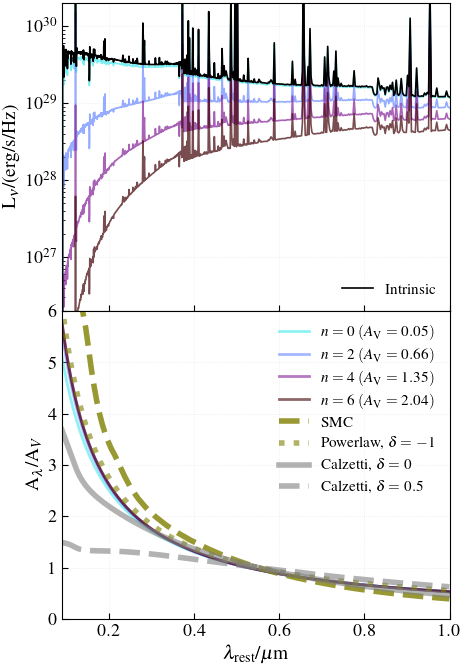

In [5]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(5, 8), sharex=True, sharey=False, facecolor='w', edgecolor='k')
axs = axs.ravel()

req_gal = 0

req_sed = sed_emergent[req_gal]
req_att_curve = att_curve[req_gal]
req_Av = Av[req_gal]

for ii in range(4):
    color = colors[ii]
    ok = np.where(grid.lam<=1e4 * Angstrom)[0]
    
    axs[0].plot(grid.lam[ok]/1e4, req_sed[ii].lnu[ok], color=color, alpha=0.7)
    axs[1].plot(grid.lam[ok]/1e4, req_att_curve[ii][ok]/req_Av[ii], label=rF'$n={nmu[ii]}$ $(A_{{\rm V}}={np.round(Av[0][ii],2)})$', alpha=0.6, lw=2, color=color)    

axs[0].plot(grid.lam[ok]/1e4, sed_int[req_gal].lnu[ok], color='black', label='Intrinsic')

c = GrainModels(model='WD01', submodel='SMC')
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='SMC', alpha=0.8, ls='dashed', lw=4, color='olive')

c = PowerLaw()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label='Powerlaw, $\delta=-1$', alpha=0.6, ls='dotted', lw=4, color='olive')

c = Calzetti2000()
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0$', alpha=0.6, ls='solid', lw=4, color='grey')

c = Calzetti2000(slope=0.5)
axs[1].plot(grid.lam[ok]/1e4, c.get_tau(grid.lam[ok])/c.get_tau(5500*Angstrom), label=r'Calzetti, $\delta=0.5$', alpha=0.6, ls='dashed', lw=4, color='grey')

for ax in axs:
    ax.grid(ls='dotted')
    ax.legend(frameon=False, fontsize=11) 
    ax.set_xlim(0.09,1)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(13)
    
axs[0].set_ylabel(r'L$_{\nu}$/(erg/s/Hz)', fontsize=14)
axs[0].set_ylim(2e26, 2e30)
axs[0].set_yscale('log')

axs[1].set_xlabel(r'$\lambda_{\rm rest}$/${\rm \mu m}$', fontsize=14)
axs[1].set_ylim(0,6)
axs[1].set_ylabel(r'A$_{\lambda}$/A$_{V}$', fontsize=14)

fig.subplots_adjust(hspace=0,wspace=0)   
plt.savefig('app_plots/app_toy_att_curves.png', dpi=300, bbox_inches='tight')   
plt.show()

#### Recovering SFR fraction of toy galaxies
Same as Figure 3 in the paper

<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/1904634775.py:47: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[1].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='lower left', framealpha=0.2, fontsize=14)
/var/folders/j_/zbbc0z3n0f1c3fncxtfwvqtr0000gq/T/ipykernel_14890/1904634775.py:50: SyntaxWarning: invalid escape sequence '\m'
  twinaxs[2].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='lower left', framealpha=0.2, fontsize=14)


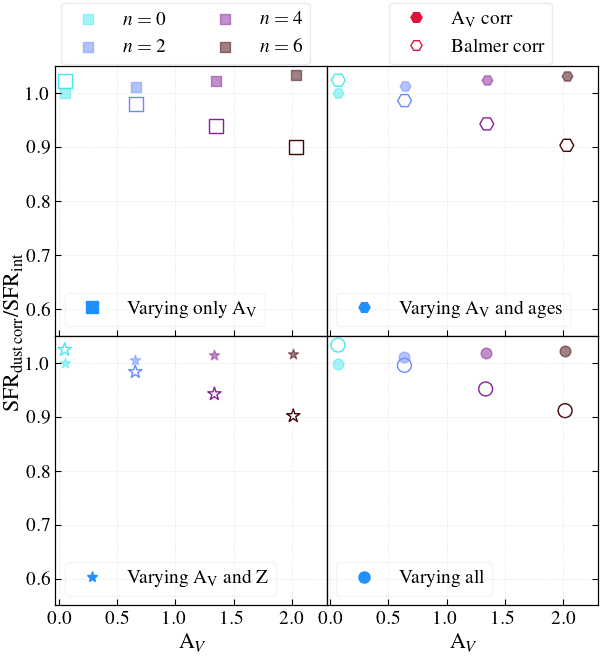

In [6]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize=(7, 7), facecolor='w', edgecolor='k', sharex=True, sharey=True)
axs = axs.ravel()
twinaxs = [ax.twinx() for ax in axs]

markers = ['s', 'H', '*', 'o']
custom = [Line2D([], [], marker=ii, markersize=8, color='dodgerblue', linestyle='None') for ii in markers]

custom_att = [Line2D([], [], marker='H', markersize=8, color='crimson', linestyle='None', markerfacecolor=ii) for ii in ['crimson', 'None']]

for jj in range(4):    
    for ii in range(num_gals):
        color = colors[ii] 
      
        # ax.scatter(Av[jj][ii], Halpha_frac_dust[jj][ii], color=color, s=30, marker=markers[jj], alpha=0.8, edgecolors='None')
        
        if jj==0:
            axs[jj].scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.5, label=rF'$n={nmu[ii]}$')
        else:
            axs[jj].scatter(Av[jj][ii], Halpha_frac_Avcorr[jj][ii], color=color, s=60, marker=markers[jj], alpha=0.5)
            
        axs[jj].scatter(Av[jj][ii], Halpha_frac_balmercorr[jj][ii], edgecolor=color, facecolor='None', s=100, marker=markers[jj])


for ax in axs:
    ax.grid(ls='dotted', alpha=0.5)
    # ax.set_xticks(np.arange(0.1,1,0.2))
    ax.set_xlim(-0.03,2.3)
    ax.set_ylim(0.55, 1.05)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(14)

for ax in twinaxs:
    ax.set_xlim(-0.03,2.3)
    ax.set_ylim(0.55, 1.05)
    ax.set_yticks([])
    ax.set_yticklabels([])

axs[1].yaxis.tick_right()
axs[3].yaxis.tick_right()

axs[-1].set_xlabel(r'A$_{V}$', fontsize=16)
axs[-2].set_xlabel(r'A$_{V}$', fontsize=16)

twinaxs[0].legend([custom[0]], [r'Varying only A$_{\mathrm{V}}$'], loc='lower left', framealpha=0.2, fontsize=14)
axs[0].legend(frameon=True, fontsize=14, loc=(0.02,1.01), ncols=2, framealpha=0.4)

twinaxs[1].legend([custom[1]], ['Varying A$_{\mathrm{V}}$ and ages'], loc='lower left', framealpha=0.2, fontsize=14)
axs[1].legend(custom_att, [r'A$_{\rm V}$ corr', r'Balmer corr'], frameon=True, fontsize=14, loc=(0.23,1.01), ncols=1, framealpha=0.4)
    
twinaxs[2].legend([custom[2]], ['Varying A$_{\mathrm{V}}$ and Z'], loc='lower left', framealpha=0.2, fontsize=14)

twinaxs[3].legend([custom[3]], ['Varying all'], loc='lower left', framealpha=0.2, fontsize=14)

fig.text(0.05, 0.5, r'SFR$_{{\rm dust\, corr}}$/SFR$_{\rm int}$', va='center', fontsize=16, rotation='vertical')

# fig.tight_layout()
fig.subplots_adjust(hspace=0,wspace=0.)

plt.savefig('app_plots/app_toy_sfr_frac.png', dpi=300, bbox_inches='tight')
plt.show()   